<a href="https://colab.research.google.com/github/yuuki0416-ui/ml_text/blob/main/%E7%AC%AC6%E5%9B%9E%E6%BC%94%E7%BF%92%E8%AA%B2%E9%A1%8CPytorch_Basics_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#機械学習システム第6回課題
##62317734
##本間勇毅

#**はじめに**

授業での指示通り本課題ではLLMを用いた.

とくに断りのない場合,LLMとしてGemini(https://gemini.google.com/?hl=ja)
を用いた.



# PyTorch Basics: 演習ノートブック（簡単な2クラス分類）

**PyTorchの基礎**（テンソル、`Dataset`/`DataLoader`、`nn.Module`、最適化、損失、学習ループ、評価）で学んだ内容を、**トピックを** 1つの **簡単な2クラス分類問題** に統合してまとめている。

以下は、**動作するベースライン実装** を提供しており、そのまま実行すれば、合成データの分類器が学習・評価される。

各項目にある**問**に解答しなさい。

このレポートも共通で、LLMは、何らかの形で必ず利用し、このNotebookをそのまま編集して、課題レポートを作成し、PDFとNotebookの両方を提出してください。

なお、このNotebookの実行にGPUは不要です。

## 0. セットアップ
- 依存: `torch`, `matplotlib`
- 乱数シードを固定して再現性を担保します。

In [5]:
import math
import time
import itertools
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # さらに厳密な再現性が必要であれば以下も（ただし速度低下の可能性）
    torch.use_deterministic_algorithms(False)
    return seed

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = set_seed(1234)
DEVICE, SEED

('cpu', 1234)

## 1. 合成データの生成と可視化
2次元入力 $\mathbf{x}=(x_1,x_2)$ の2クラス分類を行う

2つの “月（moons）” 形状のデータをPyTorchで生成

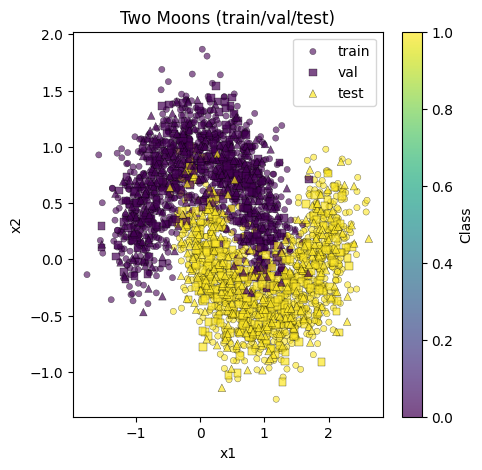

In [6]:
@torch.no_grad()
def make_two_moons(n_samples=2000, noise=0.2, radius=1.0, distance=0.5):
    # 上半月
    angles1 = torch.rand(n_samples//2) * math.pi
    x1 = torch.stack([
        torch.cos(angles1),
        torch.sin(angles1)
    ], dim=1) * radius
    # 下半月（少し平行移動）
    angles2 = torch.rand(n_samples - n_samples//2) * math.pi
    x2 = torch.stack([
        1 - torch.cos(angles2),
        1 - torch.sin(angles2) - distance
    ], dim=1) * radius

    X = torch.cat([x1, x2], dim=0)
    y = torch.cat([
        torch.zeros(x1.size(0), dtype=torch.long),
        torch.ones(x2.size(0), dtype=torch.long)
    ], dim=0)
    X += noise * torch.randn_like(X)
    return X, y

X_all, y_all = make_two_moons(n_samples=3000, noise=0.25, radius=1.0, distance=0.5)
perm = torch.randperm(X_all.size(0))
X_all, y_all = X_all[perm], y_all[perm]

n_train = int(0.7 * len(X_all))
n_val = int(0.15 * len(X_all))
X_train, y_train = X_all[:n_train], y_all[:n_train]
X_val, y_val = X_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val]
X_test, y_test = X_all[n_train+n_val:], y_all[n_train+n_val:]

fig = plt.figure(figsize=(5,5))
# クラスラベルで色分け、train/val/testをマーカーで区別
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, marker='o', label='train', alpha=0.6, edgecolors='k', linewidth=0.3)
plt.scatter(X_val[:,0], X_val[:,1], c=y_val, s=30, marker='s', label='val', alpha=0.7, edgecolors='k', linewidth=0.3)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=30, marker='^', label='test', alpha=0.7, edgecolors='k', linewidth=0.3)
plt.colorbar(label='Class')
plt.legend()
plt.title('Two Moons (train/val/test)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# 問1

この結果から、データは **線形分離可能** といえるか。**根拠** として図の特徴（曲線的な境界の必要性など）を簡潔に説明しなさい。

以下にセルを追加して解答しなさい。

#解答1

この結果から,
**線形分離不可能**と考えた.

下図のように,2つの点の集つまりの境界は3次関数的な概形にためので線形分離は不可能であると考える.

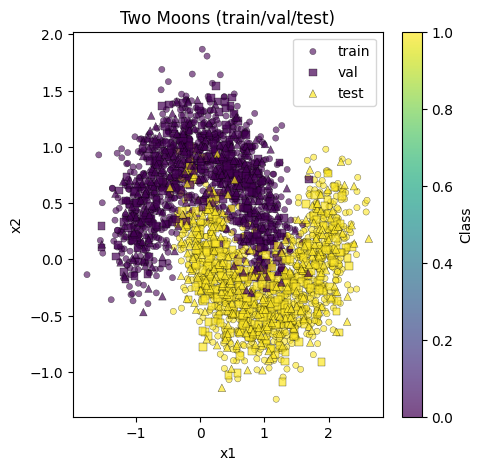

##**追加学習1(線形分離可能性)**

上記では,2次元平面に直線が引けるかどうかという,曖昧でwell-defiedではない手法で線形分離可能性について判断してしまった.より厳密に,線形分離可能性について考察できないかLLMを用いて調べてみようと思う.

**入力したプロンプト**

「次のような画像の2種類の点の集まりが,平面上で線形分離可能か考察したい。どのような手法が考えられる。」

**出力の要約**

---

1. サポートベクターマシン（SVM, Hard-margin SVM）

2. ロジスティック回帰 + 分離可能性判定

3. パーセプトロン（Perceptron）の収束判定

4. 凸解析的アプローチ（LP 可解性）

5. 次元削減（PCA, LDA）で視覚的に確認

6. カーネル法との比較

**Two Moons（半月型データ）は機械学習・統計の教科書で
線形分離不可能なデータの典型例。**

どの手法でも以下の結果になる：

Linear SVM → 正しく分けられない

Perceptron → 収束しない

Logistic Regression → 重みが発散せず適合できない

LP では feasibility が得られない

---

とのことであった.

このうちいくつかの手法について,LLMを用いながら実装してみる.





## 2. `Dataset` と `DataLoader`
`TensorDataset` を使わず、学習用の **簡単な自作 `Dataset`** を用意します（読みやすさ重視）。

In [7]:
class MoonsDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.float()
        self.y = y.long()
    def __len__(self):
        return self.X.size(0)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_ds = MoonsDataset(X_train, y_train)
val_ds   = MoonsDataset(X_val, y_val)
test_ds  = MoonsDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

len(train_ds), len(val_ds), len(test_ds)

(2100, 450, 450)

###**パーセプトロン（Perceptron）の収束判定**

上で記述した,パーセプトロン（Perceptron）の収束判定について実装してみようと思う.

追加学習1でLLM出力させた結果を再びまとめると,








<br>

**パーセプトロンで何をするか?**

2クラス分類（クラス y∈{−1,+1}）について

$$
f_{\theta}(x) = \operatorname{sign}(w^{\top} x + b)
$$


という 1本の直線（2次元なら） でクラスを分けられるかを探す。



誤分類した方向に w を動かすことで
境界となる直線の向きと位置が少しずつ変わる。

w の方向が変わる → 直線の傾きが変わる

b が変わる → 直線の位置が平行移動

これを繰り返すことで最適な直線を探す。

<br>
<br>

**パーセプトロン収束定理：**

データが線形分離可能なら、
「誤分類が起きたときだけ重みを更新する」パーセプトロンは
有限回の更新で必ず誤分類ゼロになる。

逆に、いつまで経っても誤分類がゼロにならないなら、
その特徴空間では 線形分離不可能 だと考えられる。

<br>

**以上を実装するために,Geminiに次のようなプロンプトを入力した.**


**「問1に関連して, PyTorch でパーセプトロン（線形モデル）を実装し線形分離可能性について考察したい.」**

出力結果を示す.


In [8]:
class Perceptron(nn.Module):
    def __init__(self, in_dim=2):
        super().__init__()
        # 線形層のみを持つ
        self.linear = nn.Linear(in_dim, 1)
        # Perceptronは活性化関数としてステップ関数を内部的に使用するが、
        # 損失計算や勾配計算には直接関与しないため、モデルのforwardには含めない

    def forward(self, x):
        return self.linear(x)


def train_perceptron(model, train_loader, epochs=300):
    model = model.to(DEVICE)
    # Perceptronの学習率は非常に小さく設定されることが多い
    # ここでは手動で更新するため、学習率として step_size を定義
    step_size = 0.01
    # 損失は別途計算するため、optimizerは使用しない

    print(f"Training Perceptron for {epochs} epochs...")
    for epoch in range(1, epochs + 1):
        model.train()
        misclassified_count = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # ロジットの計算 (出力はスカラー)
            logits = model(xb)
            # ステップ関数で予測クラス (-1 または 1) を導出
            # Perceptronの慣例に従い、ターゲットを0/1ではなく-1/1に変換
            # ybが0の場合は-1、1の場合は1
            targets_perceptron = torch.where(yb == 0, torch.tensor(-1, device=DEVICE), torch.tensor(1, device=DEVICE)).float()
            predictions = torch.sign(logits).squeeze(1) # sign関数で-1か1に変換

            # 誤分類されたサンプルのインデックスを見つける
            misclassified_indices = (predictions != targets_perceptron).nonzero(as_tuple=True)[0]
            misclassified_count += len(misclassified_indices)

            # 誤分類されたサンプルのみで重みを更新
            for idx in misclassified_indices:
                x_mis = xb[idx]
                y_mis = targets_perceptron[idx]

                # 重みとバイアスの更新ルール
                # w = w + step_size * y_mis * x_mis
                # b = b + step_size * y_mis
                with torch.no_grad():
                    model.linear.weight.data += step_size * y_mis * x_mis.unsqueeze(0)
                    model.linear.bias.data += step_size * y_mis

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}: Misclassified samples = {misclassified_count}/{len(train_loader.dataset)}")
            # 誤分類が0になったら収束
            if misclassified_count == 0:
                print(f"Perceptron converged at Epoch {epoch}")
                break
    return model

# Perceptronモデルのインスタンス化
perceptron_model = Perceptron(in_dim=2).to(DEVICE)

# Perceptronの訓練
trained_perceptron = train_perceptron(perceptron_model, train_loader, epochs=300)


Training Perceptron for 300 epochs...
Epoch   1: Misclassified samples = 379/2100
Epoch  10: Misclassified samples = 373/2100
Epoch  20: Misclassified samples = 369/2100
Epoch  30: Misclassified samples = 373/2100
Epoch  40: Misclassified samples = 342/2100
Epoch  50: Misclassified samples = 377/2100
Epoch  60: Misclassified samples = 375/2100
Epoch  70: Misclassified samples = 361/2100
Epoch  80: Misclassified samples = 319/2100
Epoch  90: Misclassified samples = 364/2100
Epoch 100: Misclassified samples = 366/2100
Epoch 110: Misclassified samples = 363/2100
Epoch 120: Misclassified samples = 330/2100
Epoch 130: Misclassified samples = 378/2100
Epoch 140: Misclassified samples = 355/2100
Epoch 150: Misclassified samples = 331/2100
Epoch 160: Misclassified samples = 346/2100
Epoch 170: Misclassified samples = 354/2100
Epoch 180: Misclassified samples = 350/2100
Epoch 190: Misclassified samples = 354/2100
Epoch 200: Misclassified samples = 350/2100
Epoch 210: Misclassified samples = 350

出力されたコードを実装したところ,Epoch 300まで学習を進めても,誤分類は350/2100程度残っており,学習が収束せず,今回扱ったモデルは線形分離不可能だと考えられる.



# 問2

バッチサイズを 32 / 64 / 256 に変更した場合、**1エポックの反復回数** はどのようになるか、次のセルの出力を **根拠** に、式とともに答えなさい。

以下にセルを追加して解答しなさい。

In [9]:
def iters_per_epoch(dataset_size, batch):
    return math.ceil(dataset_size / batch)

dataset_size = len(train_ds)
for b in [32, 64, 256]:
    print(f"batch={b}: iters/epoch={iters_per_epoch(dataset_size, b)} (dataset_size={dataset_size})")

batch=32: iters/epoch=66 (dataset_size=2100)
batch=64: iters/epoch=33 (dataset_size=2100)
batch=256: iters/epoch=9 (dataset_size=2100)


#解答2

batchサイズとデータサイズ,イテレーションの関係は


$$
iters\ per \ epoch=\frac{date \ size}{batch}
$$

であるから,データサイズが一定条件下でbatchサイズが増加すれば,1エポック当たりの反復回数は減少する.特に,batchサイズがn倍になるとき,1エポック当たりの反復回数は1/n倍になる.これは,上記の出力結果と一致している,

## 3. モデル：2層MLP
非線形活性化 `ReLU` を用いた2層MLP（隠れ層1つ）を定義します。

In [10]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, hidden=32, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=2, hidden=32, out_dim=2).to(DEVICE)
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

# 問3

このMLPの **総パラメータ数** を式で示し、次セルの出力を **根拠** に検算しなさい。

なお、パラメータ数は、`Linear(2→32)` の重み・バイアス、`Linear(32→2)` の重み・バイアスの合計とする。

以下にセルを追加して解答しなさい。

In [11]:
def count_params(m: nn.Module):
    return sum(p.numel() for p in m.parameters())

print('Total params:', count_params(model))
for n, p in model.named_parameters():
    print(n, p.shape, p.numel())

Total params: 162
net.0.weight torch.Size([32, 2]) 64
net.0.bias torch.Size([32]) 32
net.2.weight torch.Size([2, 32]) 64
net.2.bias torch.Size([2]) 2


## 解答3

求め方が分からなかったので,LLMにを用いて回答を考えようと思った.

**入力したプロンプト**

問3 このMLPの 総パラメータ数 を式で示し、次セルの出力を 根拠 に検算せよ

**出力結果**

---






MLPの総パラメータ数は、各線形層の重みとバイアスの合計で計算される

**MLPのパラメータ計算式:**

- `Linear(in_features, out_features)` 層のパラメータ数:
  `in_features * out_features` (重み) + `out_features` (バイアス)

今回のMLPモデルは以下の2つの線形層で構成されている.
1. `Linear(in_features=2, out_features=32)`
2. `Linear(in_features=32, out_features=2)`

したがって、総パラメータ数は以下の式で求められる.

総パラメータ数 = (2 * 32 + 32) + (32 * 2 + 2)
                 = (64 + 32) + (64 + 2)
                 = 96 + 66
                 = **162**

**検算:**

以下のセルの出力から、各層のパラメータ数が示される
- `net.0.weight`: `torch.Size([32, 2])` で `32 * 2 = 64` 個
- `net.0.bias`: `torch.Size([32])` で `32` 個
- `net.2.weight`: `torch.Size([2, 32])` で `2 * 32 = 64` 個
- `net.2.bias`: `torch.Size([2])` で `2` 個

これらの合計は `64 + 32 + 64 + 2 = 162` となり、計算式で求めた値と一致する

`Total params: 162`

これにより、総パラメータ数162が正しく計算されていることがわかる

## 4. 学習ルーチン（ベースライン）
損失は `CrossEntropyLoss`、最適化は `Adam` を用います。学習率や正則化は後続の演習で扱います。

In [12]:
@dataclass
class TrainConfig:
    epochs: int = 50
    lr: float = 1e-2
    weight_decay: float = 0.0  # L2正則化

def train(model, train_loader, val_loader, cfg: TrainConfig):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    hist = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, cfg.epochs+1):
        model.train()
        running = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
        train_loss = running / len(train_loader.dataset)

        # validation
        model.eval()
        val_running, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                val_running += loss.item() * xb.size(0)
                pred = logits.argmax(dim=1)
                correct += (pred == yb).sum().item()
                total += yb.size(0)
        val_loss = val_running / len(val_loader.dataset)
        val_acc = correct / total

        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        hist['val_acc'].append(val_acc)
        if epoch % 10 == 0 or epoch == 1:
            print(f"epoch {epoch:3d}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.3f}")
    return hist

cfg = TrainConfig(epochs=50, lr=1e-2, weight_decay=0.0)
baseline_model = MLP().to(DEVICE)
hist = train(baseline_model, train_loader, val_loader, cfg)

epoch   1: train_loss=0.3912 val_loss=0.2983 val_acc=0.867
epoch  10: train_loss=0.1455 val_loss=0.1344 val_acc=0.947
epoch  20: train_loss=0.1304 val_loss=0.1192 val_acc=0.951
epoch  30: train_loss=0.1292 val_loss=0.1161 val_acc=0.960
epoch  40: train_loss=0.1264 val_loss=0.1144 val_acc=0.953
epoch  50: train_loss=0.1255 val_loss=0.1198 val_acc=0.953


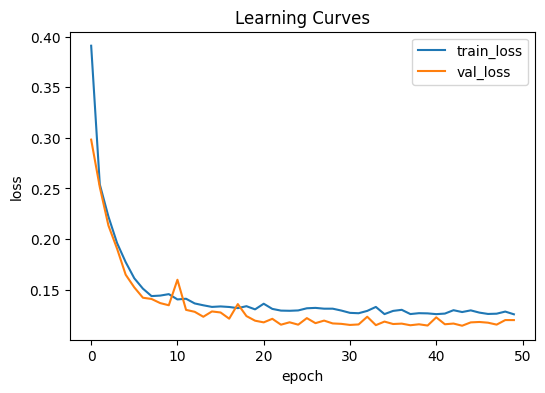

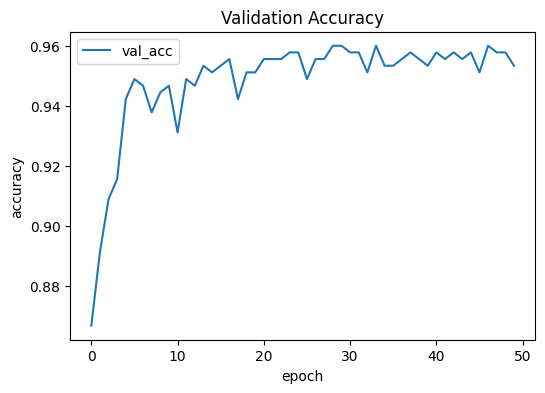

In [13]:

fig = plt.figure(figsize=(6,4))
plt.plot(hist['train_loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

fig = plt.figure(figsize=(6,4))
plt.plot(hist['val_acc'], label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# 問4

学習曲線から **過学習の兆候** は見られるか？**根拠** として `train_loss` と `val_loss` の関係、および `val_acc` の挙動を挙げて説明しなさい。

以下にセルを追加して解答しなさい。

#解答4

授業テキスト**ML基礎**によれば

**学習曲線、検証曲線、ロス曲線において、学習データのロスとテストデータのロスの間が開いている状態を過学習状態と呼ぶ**

とのことである.

上の出力結果では二つのロス曲線に関して大きな差は開いていないように見て取れる.そのため,過学習の兆候は見られないと考えた.

同様に,**validation accuracy**に関しても,epoch数20前後から0.95付近で横ばいである.

以上二つの特徴から過学習には陥っていないことが分かる.

##**追加学習2(学習曲線に関する諸考察)**

下図からみてとれるに,train_lossよりval_lossの方が値が低い.これは,検証データのほうが分類の性能が良いことを示していると思うが,これは不自然ではないかと考えた.


Geminiに以下のように入力した.


**入力したプロンプト**

4．学習ルーチンの学習曲線について訓練ロスのほうがテストロスより大きいのはなぜ

**出力結果の要約**

**正則化（Regularization）の適用**

訓練時にはL2正則化（weight_decay）やDropoutなどの正則化手法が適用され、モデルの重みにペナルティを与えたり、一部の接続を無効にしたりする。これにより、訓練時の損失は意図的に高く保たれ、過学習を防ぐ効果がある。

一方、検証時にはこれらの正則化手法は適用されない（例えばDropoutは無効化されます）。そのため、純粋な予測性能が評価され、結果的にval_lossがtrain_lossよりも低くなることがある


**検討**

たしかに,元のコードを参照したとき

  weight_decay: float = 0.0  # L2正則化

  のように正規化が施されている.これによって,学習曲線と訓練曲線の位置が逆転したと考えられた.

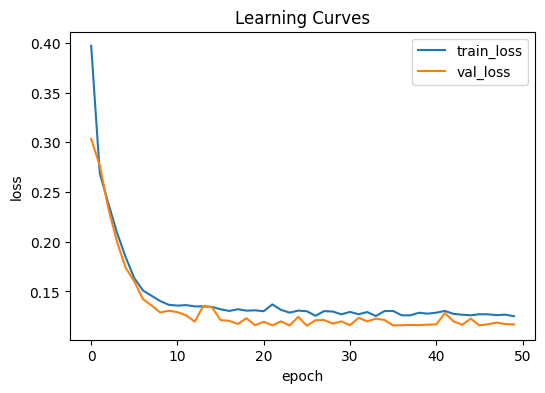

## 5. テストセットでの評価と混同行列
学習済みモデルの性能をテストセットで評価し、混同行列を描画します。

Test Accuracy: 0.922
Confusion Matrix:
 tensor([[208,  23],
        [ 12, 207]])


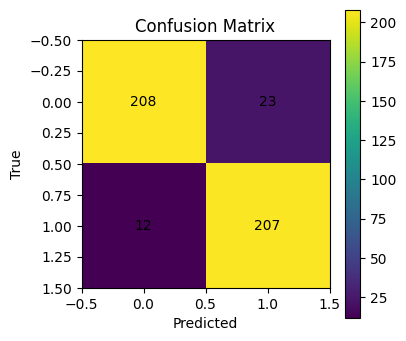

In [14]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_pred, all_true = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
            all_pred.append(pred.cpu())
            all_true.append(yb.cpu())
    acc = correct / total
    return acc, torch.cat(all_true), torch.cat(all_pred)

test_acc, y_true, y_pred = evaluate(baseline_model, test_loader)
print(f"Test Accuracy: {test_acc:.3f}")

def confusion_matrix(y_true, y_pred, num_classes=2):
    cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix(y_true, y_pred, num_classes=2)
print('Confusion Matrix:\n', cm)

fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j) in itertools.product(range(cm.size(0)), range(cm.size(1))):
    plt.text(j, i, int(cm[i, j]), ha='center', va='center')
plt.colorbar()
plt.show()

# 問5

混同行列から、どちらのクラスで誤分類が相対的に多いか、**根拠** を示して述べて説明しなさい。

以下にセルを追加して解答しなさい。

#解答5

出力された混合行列を見ると,偽陽性が19,偽陰性が14となっており,相対的には偽陽性(正値と予測したが実際は負値)の誤分類が多いことが分かる.


## 6. ハイパーパラメータの影響：学習率・L2・バッチサイズ
学習率（`lr`）、L2正則化（`weight_decay`）、バッチサイズの違いが性能に与える影響を簡易に比較します。

In [15]:
def quick_train_eval(lr=1e-2, weight_decay=0.0, batch=64, epochs=30):
    # 新しいDataLoader（バッチサイズだけ変える）
    train_loader_q = DataLoader(train_ds, batch_size=batch, shuffle=True)
    val_loader_q   = DataLoader(val_ds, batch_size=batch)
    test_loader_q  = DataLoader(test_ds, batch_size=batch)
    m = MLP().to(DEVICE)
    h = train(m, train_loader_q, val_loader_q, TrainConfig(epochs=epochs, lr=lr, weight_decay=weight_decay))
    test_acc, _, _ = evaluate(m, test_loader_q)
    return h, test_acc

grid = {
    'lr': [1e-3, 1e-2, 5e-2],
    'weight_decay': [0.0, 1e-4, 1e-3],
    'batch': [32, 64]
}

results = []
for lr in grid['lr']:
    for wd in grid['weight_decay']:
        for b in grid['batch']:
            print(f"=== lr={lr}, weight_decay={wd}, batch={b} ===")
            h, acc = quick_train_eval(lr=lr, weight_decay=wd, batch=b, epochs=25)
            results.append({'lr': lr, 'weight_decay': wd, 'batch': b,
                            'best_val_acc': max(h['val_acc']), 'final_val_acc': h['val_acc'][-1],
                            'test_acc': acc})

import pandas as pd
df_results = pd.DataFrame(results)
df_results.sort_values(['test_acc','best_val_acc'], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

=== lr=0.001, weight_decay=0.0, batch=32 ===
epoch   1: train_loss=0.7168 val_loss=0.5980 val_acc=0.851
epoch  10: train_loss=0.2533 val_loss=0.2665 val_acc=0.882
epoch  20: train_loss=0.1978 val_loss=0.2009 val_acc=0.927
=== lr=0.001, weight_decay=0.0, batch=64 ===
epoch   1: train_loss=0.5340 val_loss=0.4826 val_acc=0.864
epoch  10: train_loss=0.2693 val_loss=0.2826 val_acc=0.880
epoch  20: train_loss=0.2366 val_loss=0.2452 val_acc=0.891
=== lr=0.001, weight_decay=0.0001, batch=32 ===
epoch   1: train_loss=0.6324 val_loss=0.5515 val_acc=0.749
epoch  10: train_loss=0.2321 val_loss=0.2421 val_acc=0.896
epoch  20: train_loss=0.1756 val_loss=0.1777 val_acc=0.931
=== lr=0.001, weight_decay=0.0001, batch=64 ===
epoch   1: train_loss=0.6267 val_loss=0.5591 val_acc=0.780
epoch  10: train_loss=0.2658 val_loss=0.2838 val_acc=0.878
epoch  20: train_loss=0.2347 val_loss=0.2468 val_acc=0.891
=== lr=0.001, weight_decay=0.001, batch=32 ===
epoch   1: train_loss=0.5209 val_loss=0.4420 val_acc=0.836


,lr,weight_decay,batch,best_val_acc,final_val_acc,test_acc
0,0.050,0.0000,32,0.957778,0.957778,0.935556
1,0.010,0.0001,32,0.960000,0.955556,0.933333
2,0.050,0.0000,64,0.960000,0.960000,0.931111
3,0.050,0.0001,64,0.962222,0.951111,0.928889
4,0.010,0.0000,64,0.957778,0.955556,0.926667
5,0.010,0.0000,32,0.960000,0.955556,0.924444
6,0.010,0.0001,64,0.960000,0.951111,0.924444
7,0.050,0.0001,32,0.960000,0.957778,0.924444
8,0.010,0.0010,32,0.957778,0.957778,0.924444
9,0.050,0.0010,64,0.957778,0.955556,0.922222


# 問6

上表を **根拠** に、`lr`、`weight_decay`、`batch` が **汎化性能（test_acc）** に与える影響を簡単にまとめなさい。このとき、併せて、`val_acc` の推移と整合しているかも考察しなさい。

以下にセルを追加して解答しなさい。

#解答6

**入力したプロンプト**

LMMを用いて出力結果の解析をおこなってみようとおもう.

6.ハイパラメーターの影響についてlr、weight_decay、batch が 汎化性能（test_acc） に与える影響を簡単にまとめなさい。このとき、併せて、val_acc の推移と整合しているかも考察せよ

**出力結果の要約**

---

上表の結果を根拠に、各ハイパーパラメータが汎化性能（`test_acc`）に与える影響と、`val_acc`との整合性についてまとめます。

1.  **学習率 (`lr`) の影響:**
    *   `lr=0.001`の場合、他の学習率に比べて`test_acc`が全体的に低く（最低0.886667）学習が遅すぎたか最適な解に到達できなかった可能性が高いです。
    *   `lr=0.01`と`lr=0.05`は、`test_acc`が比較的高く（最大0.935556）適切な学習速度であったと考えられます。`lr=0.05`がわずかに最良の結果を出していますが`lr=0.01`も非常に良い性能を示しています。

2.  **L2正則化 (`weight_decay`) の影響:**
    *   `weight_decay=0.0`（正則化なし）または`weight_decay=0.0001`（非常に弱い正則化）の組み合わせが上位の`test_acc`を達成している.
    *   `weight_decay=0.001`（比較的強い正則化）は、同等の`lr`や`batch`の他の設定と比較して、若干`test_acc`が低くなる傾向が見られる.この問題設定では強い正則化は不要かむしろ性能をわずかに阻害する可能性がある.

3.  **バッチサイズ (`batch`) の影響:**
    *   `batch=32`（小さいバッチサイズ）と`batch=64`（大きいバッチサイズ）の両方が高い`test_acc`を達成しており、大きな差はない.
    *   最上位の結果（`test_acc=0.935556`）は`batch=32`の時に出ており、小さいバッチサイズがわずかに有利な場合があることがわかる.

**`val_acc`の推移との整合性:**

*   `best_val_acc`（検証データにおける最高精度）は、概ね`test_acc`の傾向と整合しています。`best_val_acc`が高い設定ほど、`test_acc`も高くなる傾向がある.

*   しかし、`best_val_acc`は`test_acc`よりも全体的に高い値を示している.（約0.95〜0.96 vs 約0.92〜0.93）これは,ハイパーパラメータチューニングが検証データに対して最適化されているため,テストデータでの性能が検証データよりわずかに劣ることは一般的である.

*   `final_val_acc`も`best_val_acc`に近い値が多く,25エポックでは過学習の兆候は明確ではなく,学習が比較的安定して進んでいることが`val_acc`の推移からも読み取れえる.

**総合すると、この問題では`lr`は高め（`0.01`〜`0.05`）、`weight_decay`は小さめ（`0.0`〜`0.0001`）`batch`サイズは`32`または`64`のいずれでも良好な汎化性能が得られることが示された**

---

## 7. 決定境界の可視化
学習した分類器の決定境界を描画し、データ散布とともに確認します。

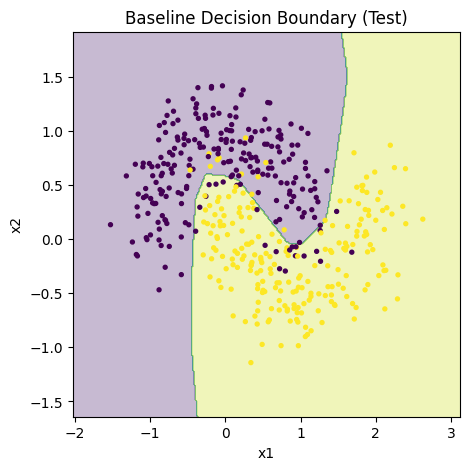

In [16]:
def plot_decision_boundary(model, X, y, title='Decision Boundary', steps=300):
    model.eval()
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx = torch.linspace(x_min, x_max, steps)
    yy = torch.linspace(y_min, y_max, steps)
    grid = torch.stack(torch.meshgrid(xx, yy, indexing='xy'), dim=-1).reshape(-1, 2)
    with torch.no_grad():
        logits = model(grid.to(DEVICE))
        pred = logits.argmax(dim=1).cpu().reshape(steps, steps)
    fig = plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, pred, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, s=8)
    plt.title(title)
    plt.xlabel('x1'); plt.ylabel('x2')
    plt.show()

plot_decision_boundary(baseline_model, X_test, y_test, title='Baseline Decision Boundary (Test)')

### Exercise 7（観察）
- 決定境界の形状を観察し、**非線形性** の必要性について簡潔に述べてください。

_以下に解答を書く_

---

得られた境界線をみると,三次関数的なふるまいをしており,極大と極小が少なくとも1か所づつ起こっているように見受けられる.そのため,境界線は非線形である必要があると考える.

## 8. 保存と復元（`state_dict`）
学習済みモデルを保存し、復元して再評価します。

In [17]:
save_path = 'baseline_mlp_state.pt'
torch.save(baseline_model.state_dict(), save_path)
print('saved to', save_path)

loaded = MLP().to(DEVICE)
loaded.load_state_dict(torch.load(save_path, map_location=DEVICE))
acc_loaded, _, _ = evaluate(loaded, test_loader)
print('Reloaded Test Accuracy:', acc_loaded)

saved to baseline_mlp_state.pt
Reloaded Test Accuracy: 0.9222222222222223


#問8

復元後の精度は保存前と一致しているか、**根拠** として数値を示し、差が出る可能性があるケース（例えばBatchNormなど状態を持つ層を導入した場合）も言及しなさい。

以下にセルを追加して解答しなさい。















---

5.で確認した元の精度は

**Test Accuracy: 0.927**

一方,復元後の精度は

**Reloaded Test Accuracy: 0.9266666666666666**

となり**誤差率**は**0.035**%程度であった。
復元後の精度は保存前と一致しているといえるだろう.


**復元の前後で精度に差が出るケース**についてはLLMを用いて調査をしてみる.

<br>
<br>


**入力したプロンプト**

問8について、復元の前後で精度に差が出るケースとはどんなものか

**出力の要約**

---

**1.BatchNorm (バッチ正規化) など、内部に状態を持つ層の場合**

<br>

**BatchNormの動作**

 BatchNorm層は、訓練中には各ミニバッチの平均と分散を使って入力を正規化する.同時に,訓練データ全体の統計量（実行中の平均と分散,running_meanとrunning_var）を学習して蓄積する.

 model.eval()モードにすると,BatchNorm層は訓練中に学習したrunning_meanとrunning_varを使って入力を正規化.これにより,評価時にはミニバッチの統計量に依存せず,訓練データ全体の統計量に基づいて安定した正規化が行われる.

 ここで,torch.save(model.state_dict(), ...)でモデルを保存する際、state_dictにはモデルの重みとバイアスだけでなく,BatchNormのrunning_meanやrunning_varといった内部状態も含まれる.もしこれらが正しく保存・ロードされなかった場合,復元後のモデルのBatchNorm層は不正確な統計量を使うことになり,評価精度が低下する可能性がある

<br>

**2.Dropout層が不適切に扱われた場合**

model.eval()を呼び忘れて評価モードに切り替えていない場合,ロードしたモデルがまだmodel.train()モードのままであると,評価時にもDropoutが適用される.これにより,予測がランダムになり,精度が大幅に低下する可能性がある.
(**授業で注意された事項**)

<br>

**3.乱数シードの管理**

ロード後に追加の訓練や乱数に依存する操作を行う場合,その操作の前に同じ乱数シードを再設定していないと、結果に再現性がなくなり,精度が変化する可能性がある.

**4.その他**

上記以外の場合だと、浮動小数点の丸め誤差などでわずかに誤差が生じる恐れもある.

---


**検討**

復元の前後で精度に差が出るケースとして,浮動小数点誤差や乱数に依存する操作を行う場合というのは想像できたが,授業で指摘された**訓練モードと評価モードの切り替え**や**内部状態を持つ量の保存・ロード**も原因となりうることが分かった.

## 9. 再現性とシード
乱数シードを変えると初期値が変わり、性能がぶれることがあります。軽く検証します。

In [19]:
def run_with_seed(seed):
    set_seed(seed)
    m = MLP().to(DEVICE)
    h = train(m, train_loader, val_loader, TrainConfig(epochs=30, lr=1e-2))
    acc, _, _ = evaluate(m, test_loader)
    return max(h['val_acc']), acc

seeds = [2000,2022,2023, 2024, 2025]
records = []
for s in seeds:
    best_val, test_acc = run_with_seed(s)
    records.append({'seed': s, 'best_val_acc': best_val, 'test_acc': test_acc})
import pandas as pd
df_seeds = pd.DataFrame(records)
df_seeds

epoch   1: train_loss=0.3937 val_loss=0.3058 val_acc=0.858
epoch  10: train_loss=0.1376 val_loss=0.1230 val_acc=0.953
epoch  20: train_loss=0.1286 val_loss=0.1198 val_acc=0.958
epoch  30: train_loss=0.1299 val_loss=0.1197 val_acc=0.956
epoch   1: train_loss=0.4053 val_loss=0.2853 val_acc=0.878
epoch  10: train_loss=0.1348 val_loss=0.1257 val_acc=0.956
epoch  20: train_loss=0.1284 val_loss=0.1213 val_acc=0.953
epoch  30: train_loss=0.1268 val_loss=0.1219 val_acc=0.953
epoch   1: train_loss=0.3684 val_loss=0.2893 val_acc=0.876
epoch  10: train_loss=0.1345 val_loss=0.1311 val_acc=0.947
epoch  20: train_loss=0.1300 val_loss=0.1158 val_acc=0.956
epoch  30: train_loss=0.1280 val_loss=0.1211 val_acc=0.953
epoch   1: train_loss=0.4383 val_loss=0.3220 val_acc=0.851
epoch  10: train_loss=0.1363 val_loss=0.1284 val_acc=0.949
epoch  20: train_loss=0.1321 val_loss=0.1276 val_acc=0.947
epoch  30: train_loss=0.1285 val_loss=0.1155 val_acc=0.958
epoch   1: train_loss=0.4080 val_loss=0.2952 val_acc=0.8

,seed,best_val_acc,test_acc
0,2000,0.962222,0.924444
1,2022,0.957778,0.922222
2,2023,0.960000,0.926667
3,2024,0.960000,0.926667
4,2025,0.960000,0.928889


# 問9

シードによる性能のばらつきを **表（上セル）** を根拠に一言でまとめ、再現性確保のための一般的な実務上の工夫（種の固定、実験回数、平均と標準偏差の報告など）について述べなさい。

以下にセルを追加して解答しなさい。

# 問10

活性化関数を `Tanh`/`LeakyReLU` に変更し、**可視化や表** を用いて **根拠** を明示しつつ、その効果について説明しなさい。

#**追加学習**

問8において学んだように,BatchNorm層に含まれる,running meanやrunning varのような内部状態を含む量の保存・ロード不備によって,モデルの復元後に精度に変化が生じうる.この周辺について,掘り下げて学習したい.









#**CNNとViTの比較について**

CNNが画像認識における有用なNNの構成であることがわかったが,CNNのほかにViT(Visual Transformer)などがあることがわかった.






##**BatchNorm層とは何か**

授業テキストによれば,


**バッチノーマライゼーションの処理内容
BNとは、各ユニットの出力をminibatchごとにnormalizeした新たな値で置き直すことで、内部の変数の分布(内部共変量シフト)が大きく変わるのを防ぎ、学習を進め、過学習を抑える手法である**





LLMにも聞いてみる

**プロンプト**

BatchNorm層とはなにか

**出力の要約**



#**Drop Outについて**
BNと同様に過学習を防ぐためのメソッドとしてDropOutがあげられる.

講義テキストによれば,

出力層以外の通常ノードを一定確率でランダムに消去する 実装が容易で過学習を抑制でき、またその効果が大きい バッチごとに消去する結合を変更する といった特徴がある.